In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint
from prophet import Prophet

In [139]:
df = pd.read_csv("../data/dfgeopoli.csv")

In [140]:
df.columns

Index(['Unnamed: 0', 'year', 'country_id_o', 'country_o', 'country_id_d',
       'country_d', 'contig', 'distcap', 'dist', 'comlang_off',
       'comlang_ethno', 'comrelig', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d',
       'gdpcap_o', 'gdpcap_d', 'fta_wto', 'tradeflow_comtrade_o',
       'tradeflow_comtrade_d', 'tradeflow_imf_o', 'tradeflow_imf_d',
       'IdealPointDistance', 'arms', 'tot_o', 'tot_d', 'tgdp_ratio_o',
       'tgdp_ratio_d', 'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o',
       'v2x_delibdem_o', 'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d',
       'v2x_partipdem_d', 'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports',
       'chemicalexports', 'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'log_tradeflow_comtrade_o',
       'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff',
     

In [141]:
X = df.dropna(subset=['gdpcap_d'])[['geodistance', 'distcap', 'gdpcap_d', 'pop_d']]
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df) # no large multicollinearity present

       Feature       VIF
0  geodistance  5.608730
1      distcap  5.288182
2     gdpcap_d  1.265124
3        pop_d  1.049985


### Creating lag values

In [142]:
# Sorting by (country_d, year)
df_2 = df.sort_values(by=['country_d', 'year'])

# Set lag variables
df_2['lag_pop_d'] = df_2.groupby('country_d')['pop_d'].shift(1)
df_2['lag_gdpcap_d'] = df_2.groupby('country_d')['gdpcap_d'].shift(1)

df_2 = df_2[df_2.groupby('country_d')['year'].diff() == 1]

df_2 = df_2.dropna(subset=['geodistance', 'lag_pop_d', 'lag_gdpcap_d', 'log_tradeflow_comtrade_o', 'log_tradeflow_comtrade_o'])

In [143]:
df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']].corrwith(df_2['log_tradeflow_comtrade_o'])

# makes sense, expect the signs of each variable

geodistance    -0.180455
distcap        -0.319656
lag_gdpcap_d    0.376160
lag_pop_d       0.326401
dtype: float64

In [144]:
# TimeSeriesSplit Cross-validation function
def timeseries_cv(model, X, y, folds = 6):
    tscv = TimeSeriesSplit(n_splits=folds) # around 5 years per fold, there are 32 years in total
    mse_list = []
    r2_list = []
    mae_list = []
    mape_list = []
    
    predictions = pd.Series(index=y.index, dtype=float)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        if hasattr(X, 'iloc'): # this is because some models uses the np, some uses pandas
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        if hasattr(y, 'iloc'): # this is because some models uses the np, some uses pandas
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        mae_list.append(mae)
        mape_list.append(mape)
        
        predictions.loc[y_test.index] = pd.Series(y_pred.flatten(), index=y_test.index)

    metrics = {
        'avg_mse': np.mean(mse_list), 
        'avg_r2': np.mean(r2_list), 
        'avg_mae': np.mean(mae_list), 
        'avg_mape': np.mean(mape_list),
        'folds': folds
    }

    return predictions, metrics

In [145]:
# Linear Regression
df_2 = df_2.sort_values(by=['year'])
linearX = df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']]
linearY = df_2[['log_tradeflow_comtrade_o']]

scaler = StandardScaler()
linearX = scaler.fit_transform(linearX)

linearModel = LinearRegression()

linearPredictions, linearMetrics = timeseries_cv(linearModel, linearX, linearY)
print(linearMetrics)

{'avg_mse': 5.322610258733652, 'avg_r2': 0.2568239805836335, 'avg_mae': 1.7073388573840227, 'avg_mape': 0.10061310598545979, 'folds': 6}


In [146]:
# XGBoost
xgboostX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
xgboostX['log_lag_pop_d'] = np.log1p(xgboostX['lag_pop_d'])
xgboostX['log_lag_gdpcap_d'] = np.log1p(xgboostX['lag_gdpcap_d'])

xgboostX = xgboostX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
xgboostY = df_2[['log_tradeflow_comtrade_o']]

# need to relook at the settings
xgboostModel = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

xgboostPredictions, xgboostMetrics = timeseries_cv(xgboostModel, xgboostX, xgboostY)
print(xgboostMetrics)

{'avg_mse': 1.9125371126414168, 'avg_r2': 0.7343794007577, 'avg_mae': 1.022296494134362, 'avg_mape': 0.062004416486577785, 'folds': 6}


In [147]:
# Hyperparameter tuning for XGBoost
tscv = TimeSeriesSplit(n_splits=6)

# Hyperparameter to try
xgboost_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# RandomizedSearchCV for hyperparameter tuning using tscv
xgboost_random_search = RandomizedSearchCV(
    estimator=xgboostModel,
    param_distributions=xgboost_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50 
)

xgboost_random_search.fit(xgboostX, xgboostY.values.ravel())

xgboost_best_params = xgboost_random_search.best_params_
xgboost_best_model = xgboost_random_search.best_estimator_

print(xgboost_best_params)
xgboostHPTpredictions, xgboostHPTmetrics = timeseries_cv(xgboost_best_model, xgboostX, xgboostY)
print(xgboostHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'colsample_bytree': 0.8268006507038076, 'learning_rate': 0.20688478980251357, 'max_depth': 4, 'n_estimators': 151, 'subsample': 0.9273682964722553}
{'avg_mse': 1.446935457603347, 'avg_r2': 0.7962660599588417, 'avg_mae': 0.8615421115892182, 'avg_mape': 0.05237689009529809, 'folds': 6}


In [148]:
# Random forest regression
rfX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
rfX['log_lag_pop_d'] = np.log1p(rfX['lag_pop_d'])
rfX['log_lag_gdpcap_d'] = np.log1p(rfX['lag_gdpcap_d'])
rfX = rfX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
rfY = df_2['log_tradeflow_comtrade_o']

# base settings
rfModel = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=222)

rfPredictions, rfMetrics = timeseries_cv(rfModel, rfX, rfY)
print(rfMetrics)

{'avg_mse': 1.7017109631754124, 'avg_r2': 0.7610716368165811, 'avg_mae': 0.9184384459296521, 'avg_mape': 0.05627639598718531, 'folds': 6}


In [150]:
# Hyperparameter tuning for Random forest regression (similar to earlier)
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),  
}

rf_random_search = RandomizedSearchCV(
    estimator=rfModel,
    param_distributions=rf_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50 
)

rf_random_search.fit(xgboostX, xgboostY.values.ravel())
rf_best_params = rf_random_search.best_params_
rf_best_model = rf_random_search.best_estimator_

print(rf_best_params)
rfHPTpredictions, tfHPTmetrics = timeseries_cv(rf_best_model, rfX, rfY)
print(tfHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 148}
{'avg_mse': 1.82422988940998, 'avg_r2': 0.744717673042098, 'avg_mae': 0.9623010347095837, 'avg_mape': 0.05886751475875598, 'folds': 6}


In [151]:
# LightGBM
lgbmX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
lgbmX['log_lag_pop_d'] = np.log1p(lgbmX['lag_pop_d'])
lgbmX['log_lag_gdpcap_d'] = np.log1p(lgbmX['lag_gdpcap_d'])
lgbmX = lgbmX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
lgbmY = df_2[['log_tradeflow_comtrade_o']]

lgbmModel = LGBMRegressor(n_estimators=100, max_depth=10, random_state=222, verbosity = -1) # verbosity mutes output
lgbmPredictions, lgbmMetrics =  timeseries_cv(lgbmModel, lgbmX, lgbmY)
print(lgbmMetrics)

{'avg_mse': 1.4983589888959186, 'avg_r2': 0.7889163212119535, 'avg_mae': 0.8770780638623417, 'avg_mape': 0.053280390800892696, 'folds': 6}


In [152]:
# Hyperparameter tuning for LightGBM (similar to earlier)
lgbm_param_dist = {
    'n_estimators': randint(50, 200),           
    'max_depth': randint(3, 10),                
    'learning_rate': uniform(0.01, 0.2),        
    'num_leaves': randint(20, 100),           
}

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbmModel,
    param_distributions=lgbm_param_dist,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    n_iter=50
)

lgbm_random_search.fit(lgbmX, lgbmY.values.ravel())
lgbm_best_params = lgbm_random_search.best_params_
lgbm_best_model = lgbm_random_search.best_estimator_

print(lgbm_best_params)
lgbmHPTpredictions, lgbmHPTmetrics = timeseries_cv(lgbm_best_model, lgbmX, lgbmY)
print(lgbmHPTmetrics)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'learning_rate': 0.17971803466788872, 'max_depth': 6, 'n_estimators': 162, 'num_leaves': 39}
{'avg_mse': 1.4072018188467001, 'avg_r2': 0.8010991847222284, 'avg_mae': 0.8519748074848842, 'avg_mape': 0.05165482769329913, 'folds': 6}


In [157]:
df_results = df_2[['country_d', 'log_tradeflow_comtrade_o', 'year']].copy()
df_results['linearPrediction'] = linearPredictions
df_results['xgboostHPTPrediction'] = xgboostHPTpredictions
df_results['rfHPTPrediction'] = rfHPTpredictions
df_results['lgbmHPTPrediction'] = lgbmHPTpredictions

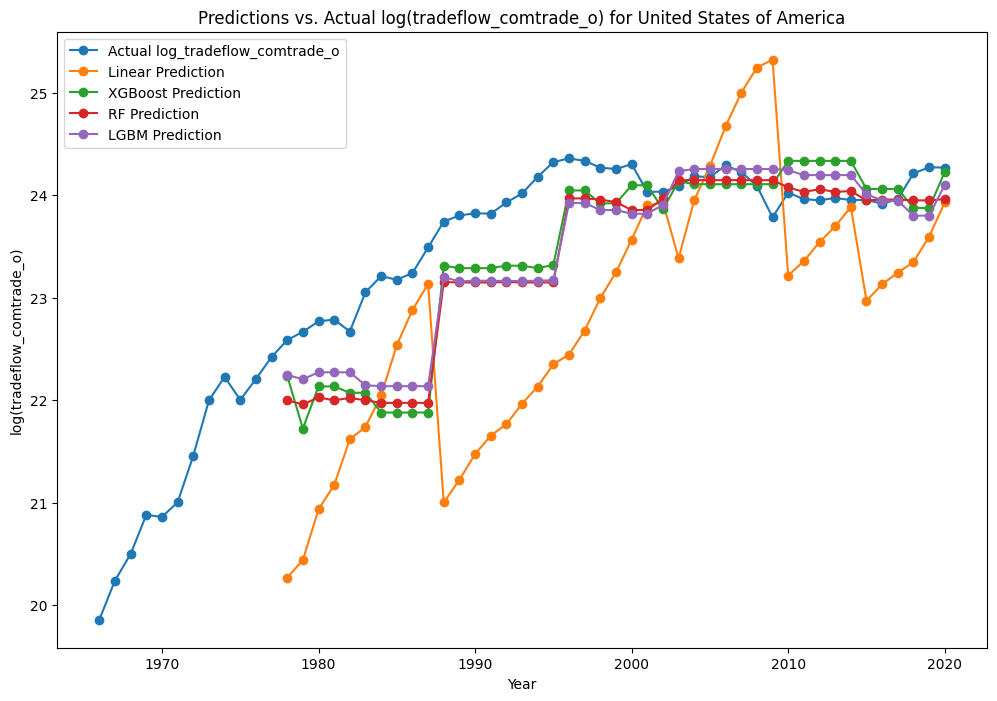

In [169]:
df_filtered = df_results[df_results['country_d'] == 'United States of America']

plt.figure(figsize=(12, 8))
plt.plot(df_filtered['year'], df_filtered['log_tradeflow_comtrade_o'], label='Actual log_tradeflow_comtrade_o', marker='o')
plt.plot(df_filtered['year'], df_filtered['linearPrediction'], label='Linear Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['xgboostHPTPrediction'], label='XGBoost Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['rfHPTPrediction'], label='RF Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['lgbmHPTPrediction'], label='LGBM Prediction', marker='o')

# Label the plot
plt.xlabel('Year')
plt.ylabel('log(tradeflow_comtrade_o)')
plt.title('Predictions vs. Actual log(tradeflow_comtrade_o) for United States of America')
plt.legend()
plt.show()

In [177]:
selected_cols = [
    'year', 'country_id_o', 'country_o', 'country_id_d',
    'country_d', 'contig', 'distcap', 'dist', 'comlang_off',
    'comlang_ethno', 'comrelig', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d',
    'gdpcap_o', 'gdpcap_d', 'fta_wto', 'tradeflow_comtrade_o', 'IdealPointDistance',
    'arms', 'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff',
    'v2x_delibdem_diff', 'v2x_egaldem_diff', 'geodistance'
]

df_last = df_2[selected_cols].copy()
df_last['Predicted'] = np.expm1(xgboostHPTpredictions)

In [178]:
df_last

,year,country_id_o,country_o,country_id_d,country_d,contig,distcap,dist,comlang_off,comlang_ethno,...,tradeflow_comtrade_o,IdealPointDistance,arms,v2x_polyarchy_diff,v2x_libdem_diff,v2x_partipdem_diff,v2x_delibdem_diff,v2x_egaldem_diff,geodistance,Predicted
3503,1966,SGP,Singapore,IRL,Ireland,0,11212.0,11212.0,1,1,...,1.447880e+06,1.994154,0,0.508,0.451,0.471,0.332,0.374,54.759338,NaN
2319,1966,SGP,Singapore,ESP,Spain,0,11396.0,10891.0,0,0,...,5.910551e+07,1.237796,0,0.231,0.190,0.063,0.179,0.148,75.956688,NaN
4122,1966,SGP,Singapore,KHM,Cambodia,0,1142.0,1142.0,0,0,...,2.365302e+07,1.068514,0,0.044,0.106,0.017,0.038,0.150,74.431393,NaN
7802,1966,SGP,Singapore,URY,Uruguay,0,15757.0,15757.0,0,0,...,7.826245e+06,1.501507,0,0.451,0.385,0.495,0.457,0.342,81.469272,NaN
7541,1966,SGP,Singapore,TUN,Tunisia,0,10256.0,10256.0,0,0,...,2.013454e+05,0.166567,0,0.120,0.110,0.037,0.033,0.087,67.872097,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,SGP,Singapore,CHE,Switzerland,0,10392.0,10308.0,0,0,...,2.040486e+09,1.110975,0,0.502,0.531,0.694,0.527,0.483,62.577661,1.138572e+09
733,2020,SGP,Singapore,BGD,Bangladesh,0,2873.0,2873.0,0,0,...,2.350055e+09,0.322395,0,0.142,0.228,0.006,0.239,0.249,70.216214,2.530387e+09
3445,2020,SGP,Singapore,IDN.2,Indonesia,0,894.0,894.0,0,1,...,2.062711e+10,0.568963,0,0.400,0.325,0.102,0.344,0.352,41.555256,4.430664e+10
3613,2020,SGP,Singapore,IRN,Iran,0,6608.0,6608.0,0,0,...,2.467961e+07,1.437981,0,0.234,0.212,0.060,0.224,0.194,75.452429,5.688787e+08


In [179]:
df_last.to_csv("../data/finaldataset.csv")